In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

import astropy.cosmology as cosmo
import astropy.units as u
import astropy.constants as const

from astropy.table import Table

from sedpy.observate import load_filters

import os

In [4]:
@u.quantity_input
def convert_janksy_to_maggies(flux_jy: u.Jy):
    flux_maggie = (flux_jy / (3631 * u.Jy)).decompose().value
    return flux_maggie

def load_prism_data(dir_name, name, version, extra_nod, units):

    # Open file
    file_name = f'{name}_prism_clear_v{version:.1f}_{extra_nod}_1D.fits'
    file_path = os.path.join(dir_name, file_name)
    hdu = fits.open(file_path)

    # Access spectral data
    wave = hdu['WAVELENGTH'].data
    flux = hdu['DATA'].data
    err = hdu['ERR'].data

    # Assign units
    wave = wave * u.m
    flux = flux * u.Unit('W / m3')
    err = err * u.Unit('W / m3')

    # Convert units
    if units == 'original':
        pass
    elif units == 'cgs':
        wave = wave.to(u.um)
        flux = flux.to(u.erg/(u.s * u.cm**2 * u.AA))
        err = err.to(u.erg/(u.s * u.cm**2 * u.AA))
    elif units == 'jy':
        wave = wave.to(u.um)
        # flux_cgs = flux.to(u.erg/(u.s * u.cm**2 * u.AA))
        # err_cgs = err.to(u.erg/(u.s * u.cm**2 * u.AA))
        # flux = flux_cgs.to(u.Jy)
        # err = err_cgs.to(u.Jy)
        flux = flux.to(u.Jy, equivalencies=u.spectral_density(wave))
        err = err.to(u.Jy, equivalencies=u.spectral_density(wave))
    elif units == 'maggies':
        wave = wave.to(u.AA)
        flux_jy = flux.to(u.Jy, equivalencies=u.spectral_density(wave))
        err_jy = err.to(u.Jy, equivalencies=u.spectral_density(wave))
        flux = convert_janksy_to_maggies(flux_jy)
        err = convert_janksy_to_maggies(err_jy)

    return wave, flux, err

In [23]:
# Load prism data
prism_dir = '/Users/Jonah/PhD/Research/quiescent_galaxies/data_processed/zf-uds-7329/spectra'
name = '007329'
version = 3.1
# name = '013079'
# version = 1.1
extra_nod = 'extr5'

wave_um, flux_cgs, err_cgs = load_prism_data(prism_dir, name, version, extra_nod, units='cgs')
wave_um, flux_jy, err_jy = load_prism_data(prism_dir, name, version, extra_nod, units='jy')
wave_A, flux_maggie, err_maggie = load_prism_data(prism_dir, name, version, extra_nod, units='maggies')

# Load prism dispersion data
disp_dir = '/Users/Jonah/PhD/Research/quiescent_galaxies/data_processed/zf-uds-7329/dispersion'
disp_name = 'jwst_nirspec_prism_disp.fits'
disp_path = os.path.join(disp_dir, disp_name)
disp_tb = Table.read(disp_path)

disp_wave = disp_tb['WAVELENGTH'].data
spec_disp = disp_tb['DLDS']
spec_res = disp_tb['R'].data

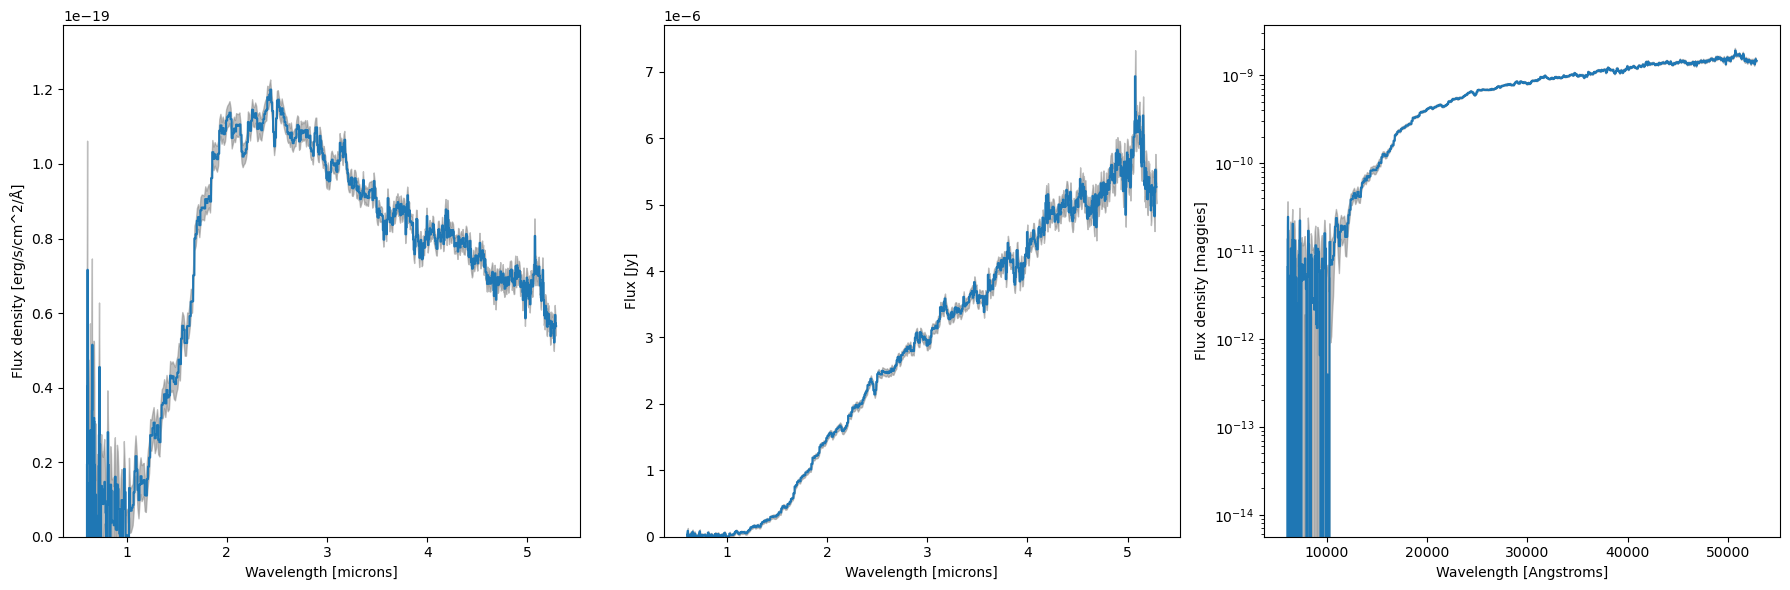

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot spectrum in cgs units
ax[0].step(wave_um, flux_cgs, where='mid')
ax[0].fill_between(wave_um.value, (flux_cgs-err_cgs).value, (flux_cgs+err_cgs).value, color='gray', alpha=0.5)
# -- prettify
ax[0].set_xlabel('Wavelength [microns]')
ax[0].set_ylabel('Flux density [erg/s/cm^2/Å]')
ax[0].set_ylim(0, None)

# Plot spectrum in janksies
ax[1].step(wave_um, flux_jy, where='mid')
ax[1].fill_between(wave_um.value, (flux_jy-err_jy).value, (flux_jy+err_jy).value, color='gray', alpha=0.5)
# -- prettify
ax[1].set_xlabel('Wavelength [microns]')
ax[1].set_ylabel('Flux [Jy]')
ax[1].set_ylim(0, None)

# Plot spectrum in maggies
ax[2].step(wave_A, flux_maggie, where='mid')
ax[2].fill_between(wave_A.value, (flux_maggie-err_maggie), (flux_maggie+err_maggie), color='gray', alpha=0.5)
# -- prettify
ax[2].set_xlabel('Wavelength [Angstroms]')
ax[2].set_ylabel('Flux density [maggies]')
# ax[2].set_xscale('log')
ax[2].set_yscale('log')

plt.tight_layout()

Text(0, 0.5, 'Resolution [dimensionless]')

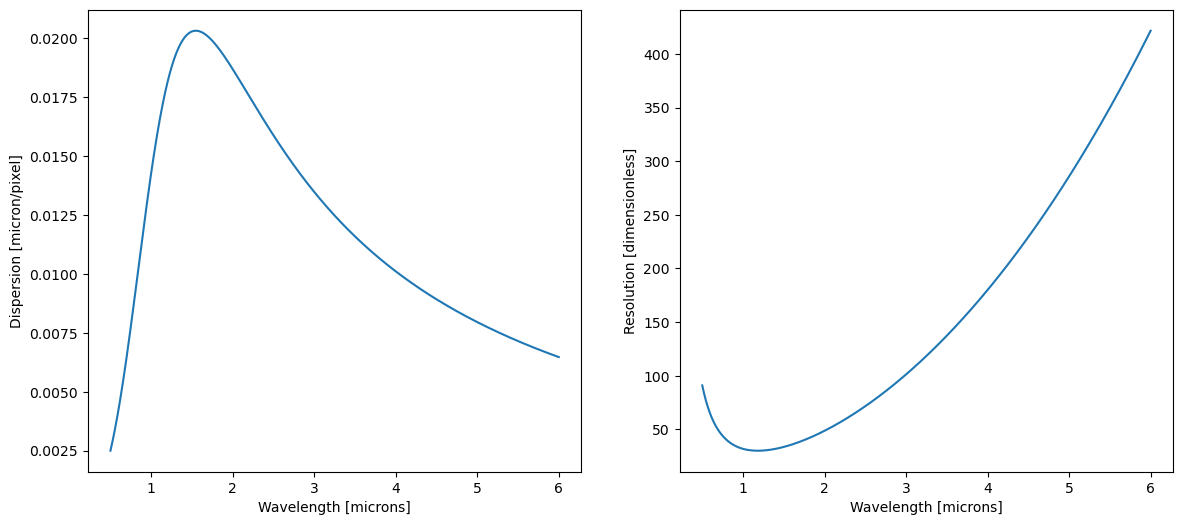

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot spectral dispersion
ax[0].plot(disp_wave, spec_disp)
ax[0].set_xlabel('Wavelength [microns]')
ax[0].set_ylabel('Dispersion [micron/pixel]')

# Plot spectral resolution
ax[1].plot(disp_wave, spec_res)
ax[1].set_xlabel('Wavelength [microns]')
ax[1].set_ylabel('Resolution [dimensionless]')